In [58]:
import os
import sys , time , traceback , datetime

from tqdm import tqdm
import warnings , ipdb
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl

#plt.style.use('ggplot')

In [9]:
%matplotlib notebook

In [2]:
warnings.filterwarnings('ignore')

In [3]:
def tsplot(y, lags=None, figsize=(12, 16), style='ggplot'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [ ]:
# fb_df = (pd.read_csv('/home/vlad/data/AMZN_und.csv',parse_dates=['last'])
#          .drop_duplicates()
#         .set_index('last'))

# fb_df.head()

In [87]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym)['Adj Close'] for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

snp500vola = get_px('SPY')
snp500vola['vola'] = (snp500vola.High - snp500vola.Low)/snp500vola.Low

snp500vola = pd.DataFrame(snp500vola.vola)

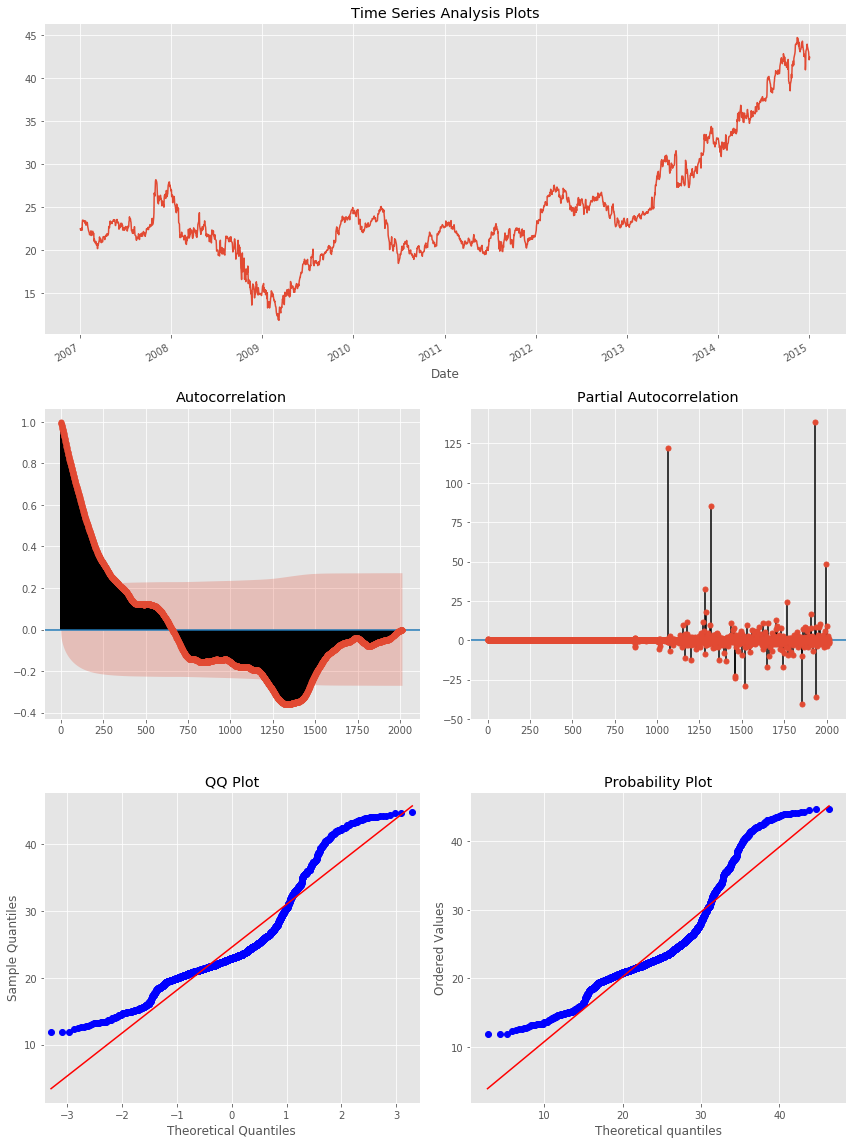

In [5]:
#TS plot 
tsplot(data.MSFT)

In [ ]:
#TS plot diff
# tsplot(data.MSFT.shift(1))

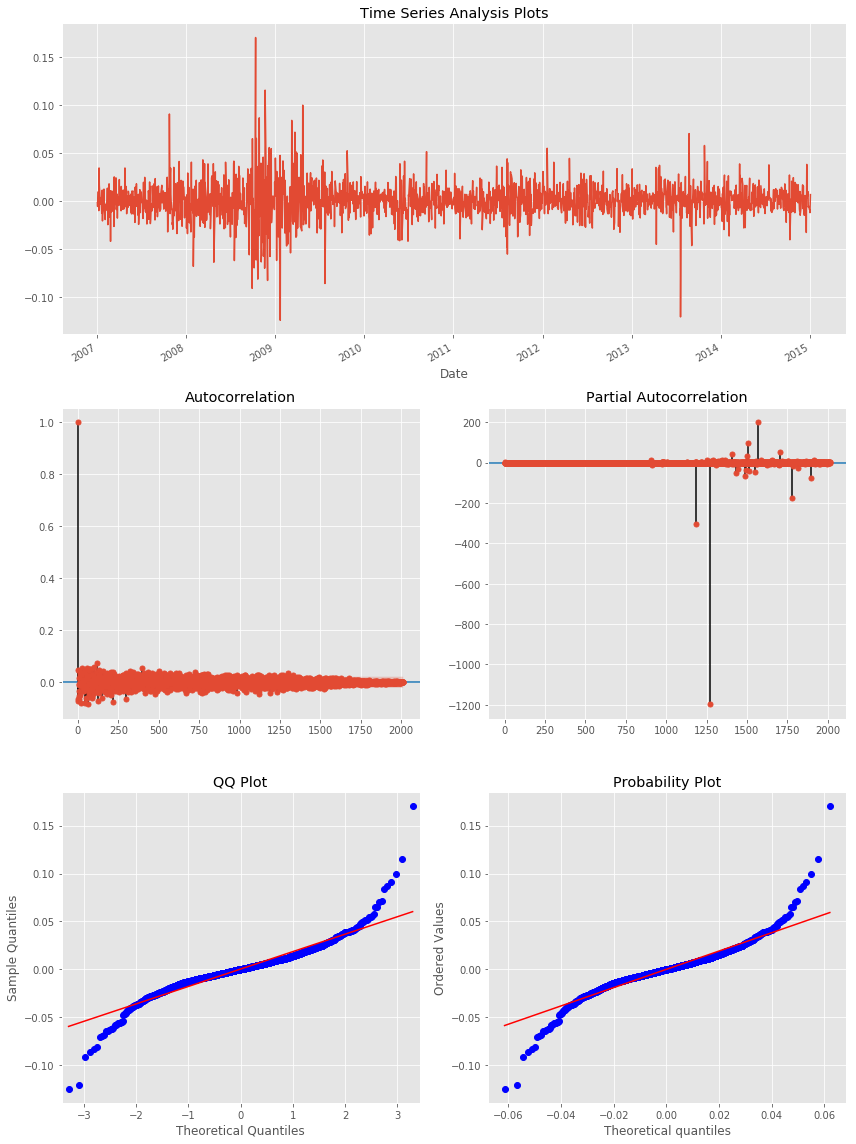

In [6]:
tsplot(lrets.MSFT)

In [ ]:
# _ = tsplot(res_tup[2].resid**2, lags=30)
#Squared residuals show autocorrelation. Let's fit a GARCH model and see how it does. 

In [5]:
#Create backtester

# Find Arima model

def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except Exception as e:
                    #print(e)
                    continue
    #print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl


def backtest_intraday(lTS=None):
    windowLength = 1450#252
    _shif = 0
    foreLength = len(lTS) - windowLength
    signal = 0*lTS[-foreLength:]
    print('Running backtesting ...')
    time.sleep(1)
    for d in tqdm(range(foreLength)):

        # create a rolling window by selecting 
        # values between d+1 and d+T of S&P500 returns
        
        TS = lTS[(1+d+_shif):(windowLength+d+_shif)] 

        # Find the best ARIMA fit 
        # set d = 0 since we've already taken log return of the series
        res_tup = _get_best_model(TS)
        order = res_tup[1]
        model = res_tup[2]
        #ipdb.set_trace()
        if order is not None:
            #now that we have our ARIMA fit, we feed this to GARCH model
            p_ = order[0]
            o_ = order[1]
            q_ = order[2]

            am = arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
            res = am.fit(update_freq=5, disp='off')

            # Generate a forecast of next day return using our fitted model
            out = res.forecast(horizon=1, start=None, align='origin')

            #Set trading signal equal to the sign of forecasted return
            # Buy if we expect positive returns, sell if negative

            signal.iloc[d] = np.sign(out.mean['h.1'].iloc[-1])
        else:
            signal.iloc[d] = np.nan
    return signal


def backtest_volamodel(lTS=None,windowLength = 500):
    foreLength = len(lTS) - windowLength
    print('Running backtesting ...')
    time.sleep(1)
    try:
        for d in tqdm(range(foreLength)):

            # create a rolling window by selecting 
            # values between d+1 and d+T of S&P500 returns
            
            TS = lTS[(1+d):(windowLength+d)].copy()
            for i in range(30):
                # Find the best ARIMA fit 
                # set d = 0 since we've already taken log return of the series
                res_tup = _get_best_model(TS)
                order = res_tup[1]
                model = res_tup[2]

                if order is not None:
                    #now that we have our ARIMA fit, we feed this to GARCH model
                    p_ = order[0]
                    o_ = order[1]
                    q_ = order[2]
                    res = (arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
                            .fit(update_freq=5, disp='off')
                          )

                    #running MonteCarlo simulations

                    ipdb.set_trace()
                    # Generate a forecast of next day return using our fitted model
                    out = (res.forecast(horizon=1, start=None, align='origin')
                           .mean['h.1']
                          .iloc[-1]
                          )
                    TS = TS.append(out)

                    #Set trading signal equal to the sign of forecasted return
                    # Buy if we expect positive returns, sell if negative

    except:
        print(traceback.print_exc())
    return signal




<IPython.core.display.Javascript object>


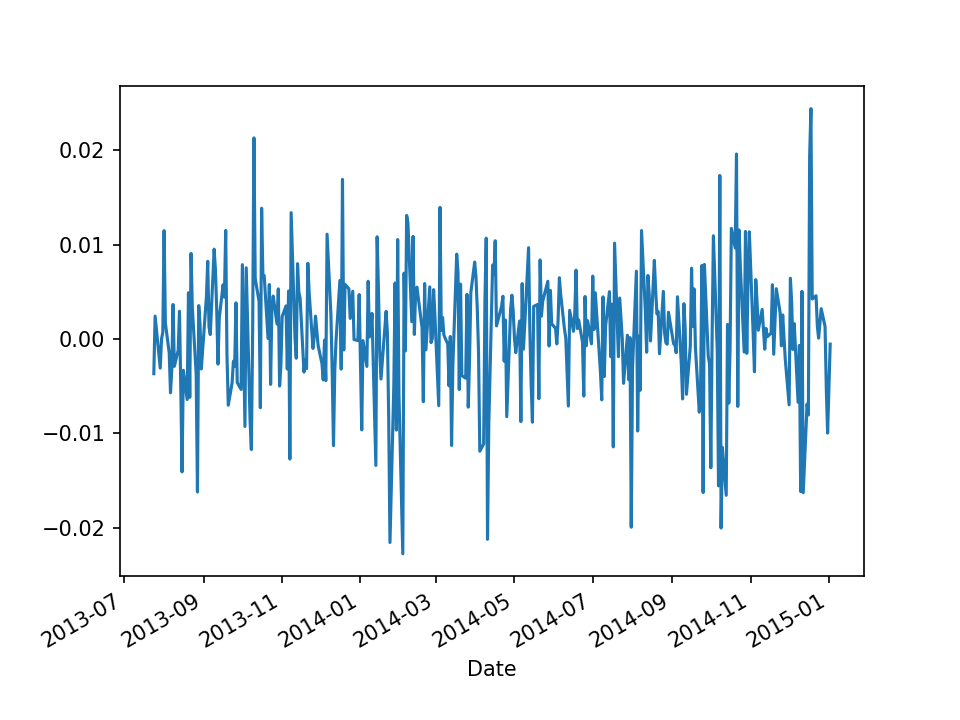

In [44]:
TS.plot()

In [6]:
windowLength = 365
TS = lrets.SPY[-windowLength:].copy()

res_tup = _get_best_model(TS)
order = res_tup[1]
model = res_tup[2]
p_ = order[0]
o_ = order[1]
q_ = order[2]
res = (arch_model(model.resid, p=p_, o=o_, q=q_, dist='StudentsT')
                            .fit(update_freq=5, disp='off')
                          )

res
#signal = backtest_volamodel(lTS = lrets.SPY)

/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


                        Constant Mean - GARCH Model Results                         
Dep. Variable:                         None   R-squared:                      -0.000
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                            GARCH   Log-Likelihood:                1097.50
Distribution:      Standardized Student's t   AIC:                          -2176.99
Method:                  Maximum Likelihood   BIC:                          -2141.90
                                              No. Observations:                  365
Date:                      Sat, Mar 30 2019   Df Residuals:                      356
Time:                              17:57:01   Df Model:                            9
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

In [167]:
def _extract_higher_variance(sim_paths):
    most_var_sim_ts = np.array([0])
    for sim in sim_paths:
        if np.var(sim) > np.var(most_var_sim_ts):
            most_var_sim_ts = sim
    return most_var_sim_ts

<IPython.core.display.Javascript object>


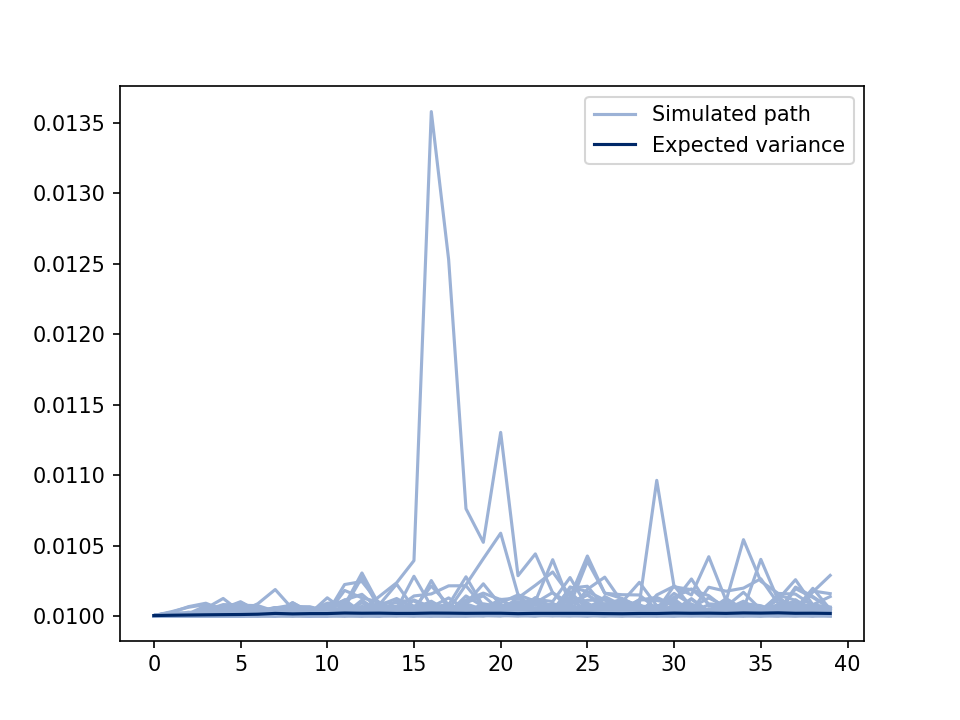

In [172]:
horizon = 40
forecast  = (res.forecast(horizon=horizon, start=None, align='origin', method='simulation')
                          # .mean['h.1']
                          #.iloc[-1]              
                          )

sims = forecast.simulations
#snp500vola

simulated_path = np.exp(sims.residual_variances[-1,:]) /100
simulated_path_plot = np.exp(sims.residual_variances[-1,::5].T) /100
expected_variance =  np.exp(forecast.variance.iloc[-1].values) /100

most_var_sim_ts = _extract_higher_variance(simulated_path)

expected_variance_ts = pd.Series(most_var_sim_ts,
                                 index=pd.DatetimeIndex(start=TS.index[-1] + datetime.timedelta(days=1)
                                                        ,end=TS.index[-1] + datetime.timedelta(days=horizon)
                                                        ,freq='D')
                                )



fig, ax = plt.subplots(1,1)
lines = plt.plot(simulated_path_plot, color='#9cb2d6')
lines[0].set_label('Simulated path')
line = plt.plot(expected_variance, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()


<IPython.core.display.Javascript object>


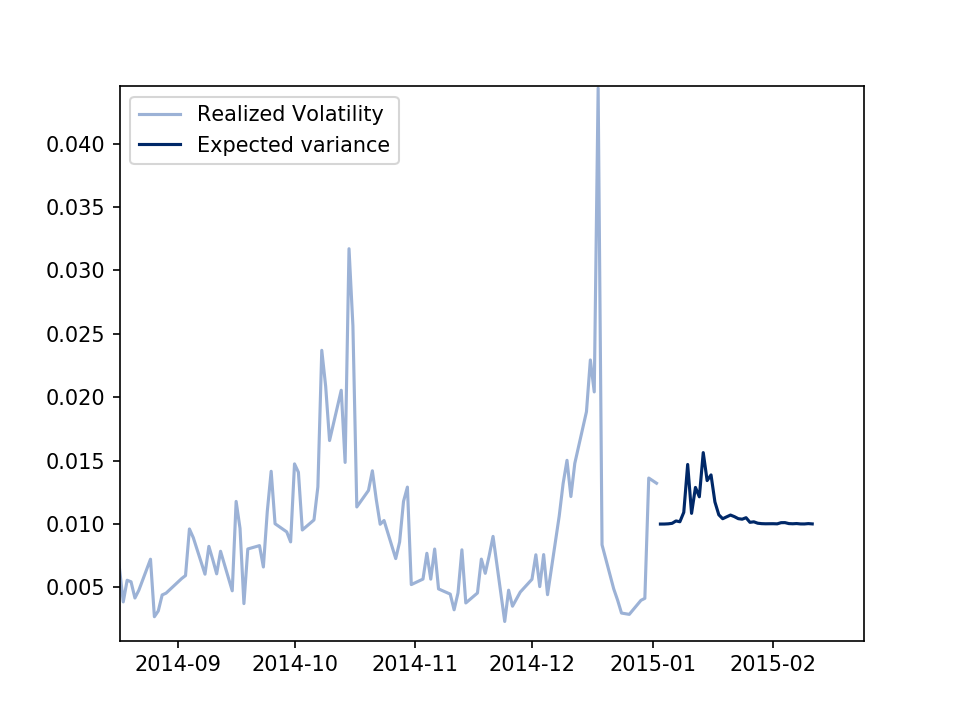

In [173]:
fig, ax = plt.subplots(1,1)
lines = plt.plot(snp500vola.iloc[-365:], color='#9cb2d6')
lines[0].set_label('Realized Volatility')
line = plt.plot(expected_variance_ts, color='#002868')
line[0].set_label('Expected variance')
legend = plt.legend()

In [8]:
signal = backtest_intraday(lTS = lrets.SPY)

Running backtesting ...


  0%|          | 0/564 [00:00<?, ?it/s]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
  0%|          | 1/564 [00:48<7:37:47, 48.79s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
  0%|          | 2/564 [01:30<7:18:08, 46.78s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
  1%|          | 3/564 [02:13<7:05:15, 45.48s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/u

  5%|▍         | 27/564 [19:30<6:12:27, 41.62s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
  5%|▍         | 28/564 [20:11<6:10:47, 41.51s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
  5%|▌         | 29/564 [20:55<6:16:58, 42.28s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
  5%|▌         | 30/564 [21:41<6:26:54, 43.47s/it]/home/vlad/anaconda

 10%|▉         | 54/564 [39:44<6:16:02, 44.24s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 10%|▉         | 55/564 [40:31<6:20:54, 44.90s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 10%|▉         | 56/564 [41:25<6:44:22, 47.76s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 10%|█         | 57/564 [42:10<6:36:50, 46.96s/it]/home/vlad/anaconda

 14%|█▍        | 81/564 [1:01:45<6:57:08, 51.82s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 15%|█▍        | 82/564 [1:02:38<6:57:58, 52.03s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 15%|█▍        | 83/564 [1:03:20<6:34:00, 49.15s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 15%|█▍        | 84/564 [1:03:59<6:09:03, 46.13s/it]

 24%|██▍       | 137/564 [1:46:25<5:27:04, 45.96s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 24%|██▍       | 138/564 [1:47:14<5:33:52, 47.02s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 25%|██▍       | 139/564 [1:48:00<5:29:15, 46.48s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 25%|██▍       | 140/564 [1:48:53<5:42:06, 48.41s/it]/home/v

 29%|██▉       | 165/564 [2:09:25<5:41:08, 51.30s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 29%|██▉       | 166/564 [2:10:18<5:42:49, 51.68s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 30%|██▉       | 167/564 [2:11:00<5:22:43, 48.77s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 30%|██▉       | 168/564 [2:11:50<5:24:51, 49.22s

 34%|███▍      | 192/564 [2:31:43<5:07:39, 49.62s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 34%|███▍      | 193/564 [2:32:28<4:58:55, 48.34s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 34%|███▍      | 194/564 [2:33:35<5:31:17, 53.72s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 35%|███▍      | 195/564 [2:34:23<5:20:02, 52.04s

 43%|████▎     | 245/564 [3:13:29<4:07:18, 46.52s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 44%|████▎     | 246/564 [3:14:19<4:12:01, 47.55s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 44%|████▍     | 247/564 [3:15:05<4:08:33, 47.04s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 44%|████▍     | 248/564 [3:15:49<4:03:08, 46.17s

 48%|████▊     | 272/564 [3:33:03<3:12:58, 39.65s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 48%|████▊     | 273/564 [3:33:38<3:04:53, 38.12s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 49%|████▊     | 274/564 [3:34:20<3:11:13, 39.57s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 49%|████▉     | 275/564 [3:35:03<3:14:49, 40.45s/it]/home/vlad/anacond

 53%|█████▎    | 301/564 [3:53:51<3:00:09, 41.10s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 54%|█████▎    | 302/564 [3:54:38<3:08:06, 43.08s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 54%|█████▎    | 303/564 [3:55:22<3:08:27, 43.32s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 54%|█████▍    | 304/564 [3:56:00<3:00:27, 41.65s

 58%|█████▊    | 328/564 [4:12:10<2:35:50, 39.62s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 58%|█████▊    | 329/564 [4:12:47<2:32:07, 38.84s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 59%|█████▊    | 330/564 [4:13:25<2:30:12, 38.51s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 59%|█████▊    | 331/564 [4:14:05<2:30:59, 38.88s/it]/home/v

 63%|██████▎   | 354/564 [4:31:57<3:15:15, 55.79s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 63%|██████▎   | 355/564 [4:32:48<3:10:14, 54.62s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 63%|██████▎   | 356/564 [4:33:52<3:18:40, 57.31s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 63%|██████▎   | 357/564 [4:35:00<3:28:47, 60.52s

 68%|██████▊   | 383/564 [10:29:46<149:35:32, 2975.32s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 68%|██████▊   | 385/564 [10:31:38<73:51:57, 1485.57s/it] /home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 68%|██████▊   | 386/564 [10:32:50<52:29:22, 1061.59s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 69%|██████▊   | 387/564 [10:33:40<37:16:08, 7

 73%|███████▎  | 411/564 [11:03:45<2:44:12, 64.40s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 73%|███████▎  | 412/564 [11:04:50<2:43:31, 64.55s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 73%|███████▎  | 413/564 [11:05:45<2:35:05, 61.63s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 73%|███████▎  | 414/564 [11:06:48<2:35:10, 62

 77%|███████▋  | 437/564 [11:31:32<1:51:43, 52.78s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 78%|███████▊  | 438/564 [11:32:20<1:47:50, 51.35s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 78%|███████▊  | 439/564 [11:33:30<1:58:28, 56.87s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 78%|███████▊  | 440/564 [11:34:37<2:04:01, 60

 82%|████████▏ | 464/564 [11:53:10<1:06:00, 39.60s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 82%|████████▏ | 465/564 [11:53:50<1:05:19, 39.59s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 83%|████████▎ | 466/564 [11:54:34<1:07:07, 41.10s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 83%|████████▎ | 467/564 [11:55:19<1:08:10, 42

 87%|████████▋ | 490/564 [12:13:57<1:06:13, 53.70s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 87%|████████▋ | 491/564 [12:15:07<1:11:21, 58.65s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 87%|████████▋ | 492/564 [12:16:01<1:08:36, 57.17s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 87%|████████▋ | 493/564 [12:16:54<1:06:04, 55

 92%|█████████▏| 517/564 [12:38:39<35:34, 45.42s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 92%|█████████▏| 518/564 [12:39:17<33:07, 43.20s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 92%|█████████▏| 519/564 [12:40:12<35:10, 46.89s/it]/home/vlad/anaconda3/lib/python3.7/site-packages/arch/univariate/base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
 92%|█████████▏| 520/564 [12:40:59<34:22, 46.88s/it]

In [14]:
% matplotlib notebook

<IPython.core.display.Javascript object>


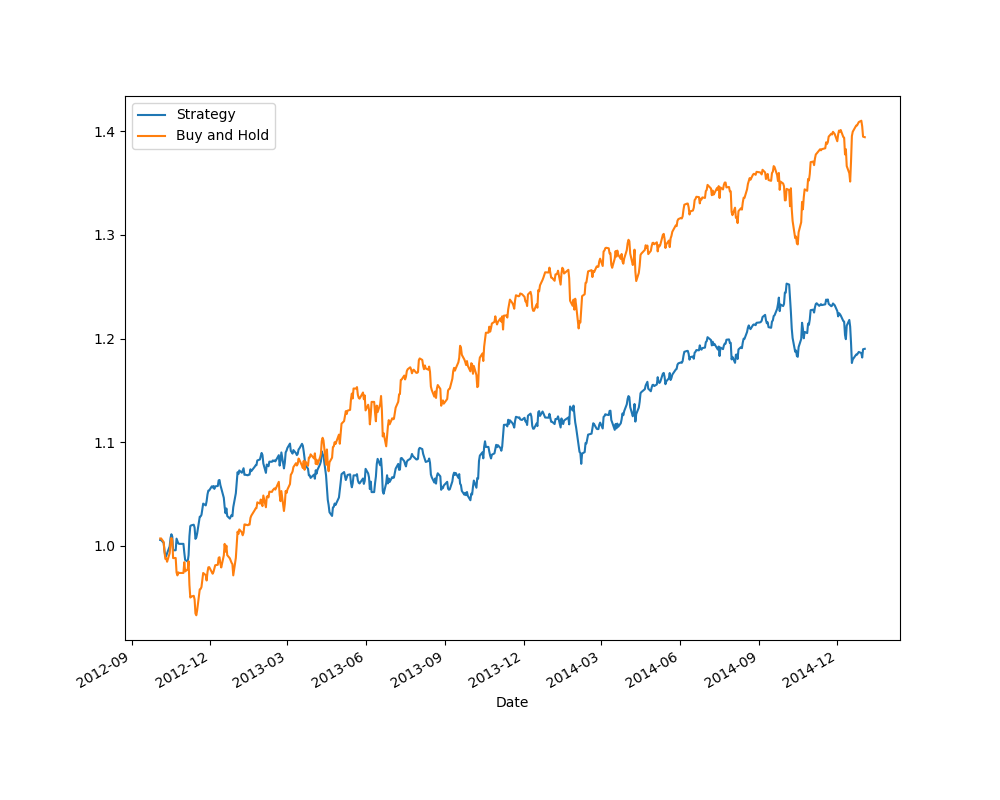

In [12]:

foreLength = len(lrets.SPY) - 1450
    
returns = pd.DataFrame(index = signal.index, 
                       columns=['Buy and Hold', 'Strategy'])
returns['Buy and Hold'] = lrets.SPY[-foreLength:]
returns['Strategy'] = signal*returns['Buy and Hold'] * .8

eqCurves = pd.DataFrame(index = signal.index, 
                       columns=['Buy and Hold', 'Strategy'])
eqCurves['Buy and Hold']=returns['Buy and Hold'].cumsum()+1
eqCurves['Strategy'] = returns['Strategy'].cumsum()+1

eqCurves['Strategy'].plot(figsize=(10,8))
eqCurves['Buy and Hold'].plot()
plt.legend()
plt.show()